In [1]:
import datetime

import h5py
import nengo
import numpy as np
import seaborn as sns
import pandas as pd
from nengo.utils.numpy import rmse
import scipy
from scipy import interpolate
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

from constants import *
from process import d3_scale

In [2]:
period = 0.5


def make_sin(freq):
    per = 2 * np.pi * freq
    
    def sin_targ(t):
        return np.sin(per*t)
    return sin_targ


def make_cos(freq):
    per = 2 * np.pi * freq
    
    def cos_targ(t):
        return 0.5*np.cos(freq*t)
    return cos_targ

def bump_func(t):
    return 1 if t < 0.1 else 0

In [3]:
from dmp_utils import *

def make_attrac_net(target_func, n_neurons=500, dd=None, num_samples=90, seed=0, label=None):

    with nengo.Network(label=label) as ad_net:

        ad_net.input = nengo.Node(size_in=1)
        ad_net.output = nengo.Node(size_in=1)
        goal = nengo.Node([0])

        attractor = gen_point_attractor(ad_net, goal, n_neurons=n_neurons, seed=seed)
        nengo.Connection(attractor[0], ad_net.output, synapse=None)

        dest = target_func(np.linspace(-np.pi, np.pi, 100)).reshape((-1, 1))
        force_func = gen_forcing_functions(dest, num_samples=num_samples)[0]

        if dd is not None:
            def conn_func(x, dec=dd, ff=force_func):
                return force_theta(x, dec, ff)
        else:
            def conn_func(x, ff=force_func):
                return force(x, ff)

        nengo.Connection(ad_net.input, attractor[1], synapse=None)

    return ad_net, conn_func

In [4]:
def run_ad(target_func, sample_num=90, seed=0):
    pre_dat = target_func(np.linspace(0, period, 100))
    xv = np.linspace(-np.pi, np.pi, pre_dat.shape[0])
    proc_func = interpolate.interp1d(xv, pre_dat)
    
    with nengo.Network() as ad_model:
        bump = nengo.Node(bump_func)
    
        osc = nengo.Network()
        osc.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
        osc.config[nengo.Ensemble].seed = seed
        nengo.networks.Oscillator(0.1, 4*np.pi, 300, net=osc)
    
        dmp, conn_func = make_attrac_net(proc_func, 300, num_samples=sample_num, seed=seed)
    
        nengo.Connection(bump, osc.ensemble[0])
        nengo.Connection(osc.ensemble, dmp.input, function=conn_func)
    
        p_out = nengo.Probe(dmp.output, synapse=0.01)
    
    with nengo.Simulator(ad_model) as ad_sim:
        ad_sim.run(4*period)
        
    return ad_sim.data[p_out][int(2*period/dt):]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
0.422765555552
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
0.52263508854
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
0.429834113001
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
0.584479365193
Building finished in 0:00:02.                                                   
Simulating finished in 0:00:02.                                                 
0.815111958295


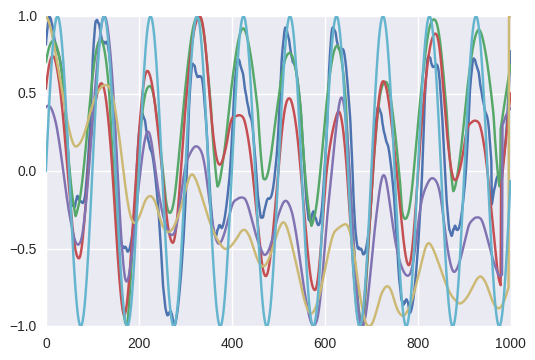

In [9]:
num_samples = [90, 500, 1000, 2000, 5000]
target_func = make_sin(10)

for ns in num_samples:
    res = run_ad(target_func, sample_num=ns, seed=0)
    tmp_res = d3_scale(res)[:, 0]
    ref_res = target_func(np.arange(0, dt*res.shape[0], dt))
    lag = np.argmax(signal.correlate(ref_res, tmp_res))
    tmp_res = np.roll(tmp_res, shift=lag)
    plt.plot(tmp_res)
    print(rmse(ref_res, tmp_res))
                    

plt.plot(ref_res)

In [6]:
print(tmp_res.shape)
print(ref_res.shape)

(1000,)
(1000,)
